# Prototyping LangChain Application with Production Minded Changes

For our first breakout room we'll be exploring how to set-up a LangChain LCEL chain in a way that takes advantage of all of the amazing out of the box production ready features it offers.

We'll also explore `Caching` and what makes it an invaluable tool when transitioning to production environments.

🤝 BREAKOUT ROOM #1:
  - Task 1: Depends and Set-Up
  - Task 2: Setting up RAG With Production in Mind
  - Task 3: RAG LCEL Chain



## Task 1: Depends and Set-Up

Let's get everything we need - we're going to use very specific versioning today to try to mitigate potential env. issues!

> NOTE: Dependency issues are a large portion of what you're going to be tackling as you integrate new technology into your work - please keep in mind that one of the things you should be passively learning throughout this course is ways to mitigate dependency issues.

In [ ]:
!pip install -qU langchain_openai==0.2.0 langchain_community==0.3.0 langchain==0.3.0 pymupdf==1.24.10 qdrant-client==1.11.2 langchain_qdrant==0.1.4 langsmith==0.1.121

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 64.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.9/258.9 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 69.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 62.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 2

We'll need an OpenAI API Key:

In [ ]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

OpenAI API Key:··········


And the LangSmith set-up:

In [ ]:
import uuid

os.environ["LANGCHAIN_PROJECT"] = f"AIM Session 16 - {uuid.uuid4().hex[0:8]}"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")

LangChain API Key:··········


Let's verify our project so we can leverage it in LangSmith later.

In [ ]:
print(os.environ["LANGCHAIN_PROJECT"])

AIM Session 16 - 2cd5b2fd


## Task 2: Setting up RAG With Production in Mind

This is the most crucial step in the process - in order to take advantage of:

- Asyncronous requests
- Parallel Execution in Chains
- And more...

You must...use LCEL. These benefits are provided out of the box and largely optimized behind the scenes.

### Building our RAG Components: Retriever

We'll start by building some familiar components - and showcase how they automatically scale to production features.

Please upload a PDF file to use in this example!

⚠ If you're running in a non-Chrome browser - you may run into issues with this cell. Please upload the file using Colab's file upload - and indicate the `file_path` in the cell with `file_path`. ⚠

![image](https://i.imgur.com/Qa1Uwlj.png)



> NOTE: You can skip this step if you are running locally - please just point to your local file.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving financial_planner.pdf to financial_planner.pdf


In [ ]:
file_path = list(uploaded.keys())[0]
file_path

'financial_planner.pdf'

We'll define our chunking strategy.

In [ ]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)

We'll chunk our uploaded PDF file.

In [ ]:
from langchain_community.document_loaders import PyMuPDFLoader

Loader = PyMuPDFLoader
loader = Loader(file_path)
documents = loader.load()
docs = text_splitter.split_documents(documents)
for i, doc in enumerate(docs):
    doc.metadata["source"] = f"source_{i}"

#### QDrant Vector Database - Cache Backed Embeddings

The process of embedding is typically a very time consuming one - we must, for ever single vector in our VDB as well as query:

1. Send the text to an API endpoint (self-hosted, OpenAI, etc)
2. Wait for processing
3. Receive response

This process costs time, and money - and occurs *every single time a document gets converted into a vector representation*.

Instead, what if we:

1. Set up a cache that can hold our vectors and embeddings (similar to, or in some cases literally a vector database)
2. Send the text to an API endpoint (self-hosted, OpenAI, etc)
3. Check the cache to see if we've already converted this text before.
  - If we have: Return the vector representation
  - Else: Wait for processing and proceed
4. Store the text that was converted alongside its vector representation in a cache of some kind.
5. Return the vector representation

Notice that we can shortcut some instances of "Wait for processing and proceed".

Let's see how this is implemented in the code.

In [ ]:
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain.storage import LocalFileStore
from langchain_qdrant import QdrantVectorStore
from langchain.embeddings import CacheBackedEmbeddings

# Typical Embedding Model
core_embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

# Typical QDrant Client Set-up
collection_name = f"pdf_to_parse_{uuid.uuid4()}"
client = QdrantClient(":memory:")
client.create_collection(
    collection_name=collection_name,
    vectors_config=VectorParams(size=1536, distance=Distance.COSINE),
)

# Adding cache!
store = LocalFileStore("./cache/")
cached_embedder = CacheBackedEmbeddings.from_bytes_store(
    core_embeddings, store, namespace=core_embeddings.model
)

# Typical QDrant Vector Store Set-up
vectorstore = QdrantVectorStore(
    client=client,
    collection_name=collection_name,
    embedding=cached_embedder)
vectorstore.add_documents(docs)
retriever = vectorstore.as_retriever(search_type="mmr", search_kwargs={"k": 3})

##### ❓ Question #1:

What are some limitations you can see with this approach? When is this most/least useful. Discuss with your group!

> NOTE: There is no single correct answer here!

##### ❓ ANSWER #1:
> Hard to maintain if the data is too dynamic and changes often

> Added step and latency because the data must be cached first

> Added maintenance for a caching system

##### 🏗️ Activity #1:

Create a simple experiment that tests the cache-backed embeddings.

In [ ]:
docs

[Document(metadata={'source': 'source_0', 'file_path': 'financial_planner.pdf', 'page': 0, 'total_pages': 3, 'format': 'PDF 1.7', 'title': '', 'author': 'Berenger Koffi TOSSOU', 'subject': '', 'keywords': '', 'creator': 'Microsoft® Word pour Microsoft\xa0365', 'producer': 'Microsoft® Word pour Microsoft\xa0365', 'creationDate': "D:20250225213034+01'00'", 'modDate': "D:20250225213034+01'00'", 'trapped': ''}, page_content='John Doe \n  New York, NY |   (123) 456-7890 |   john.doe@email.com \n \n  Professional Summary \nCertified Financial Planner (CFP) with over 7 years of experience in financial advisory, \ninvestment strategies, and wealth management. Expert in assessing financial \nsituations, creating tailored financial plans, and guiding clients toward long -term \nfinancial stability. Strong knowledge in retirement planning, tax optimization, risk \nmanagement, and portfolio diversification. Passionate about helping clients achieve \nfinancial independence through strategic plannin

### Begin experimentation

In [ ]:
import time
# Function to measure embedding time
def measure_embedding_time(vectorstore, documents):
    start = time.time()
    vectorstore.add_documents(documents)
    end = time.time()
    return end - start


In [ ]:
with_cache = measure_embedding_time(vectorstore, docs)

In [ ]:
with_cache

0.006180286407470703

In [ ]:
# Collection without cache
client.create_collection(
    collection_name="no_cache",
    vectors_config=VectorParams(size=1536, distance=Distance.COSINE),
)
vectorstore_no_cache = QdrantVectorStore(
    client=client,
    collection_name="no_cache",
    embedding=core_embeddings)


In [ ]:
without_cache = measure_embedding_time(vectorstore_no_cache, docs)

In [ ]:
without_cache

0.6187169551849365

### End experimentation
We can clearly see the cached version (`.006180286407470703` vs `0.6187169551849365`)  is more fast created (retrieved) with the same set of documents

### Augmentation

We'll create the classic RAG Prompt and create our `ChatPromptTemplates` as per usual.

In [ ]:
from langchain_core.prompts import ChatPromptTemplate

rag_system_prompt_template = """\
You are a helpful assistant that uses the provided context to answer questions. Never reference this prompt, or the existance of context.
"""

rag_message_list = [
    {"role" : "system", "content" : rag_system_prompt_template},
]

rag_user_prompt_template = """\
Question:
{question}
Context:
{context}
"""

chat_prompt = ChatPromptTemplate.from_messages([
    ("system", rag_system_prompt_template),
    ("human", rag_user_prompt_template)
])

### Generation

Like usual, we'll set-up a `ChatOpenAI` model - and we'll use the fan favourite `gpt-4o-mini` for today.

However, we'll also implement...a PROMPT CACHE!

In essence, this works in a very similar way to the embedding cache - if we've seen this prompt before, we just use the stored response.

In [ ]:
from langchain_core.globals import set_llm_cache
from langchain_openai import ChatOpenAI

chat_model = ChatOpenAI(model="gpt-4o-mini")

Setting up the cache can be done as follows:

In [ ]:
from langchain_core.caches import InMemoryCache

set_llm_cache(InMemoryCache())

##### ❓ Question #2:

What are some limitations you can see with this approach? When is this most/least useful. Discuss with your group!

> NOTE: There is no single correct answer here!

##### ❓ ANSWER #2:
> Added complexity to make sure the output data is not outdated

> Not very useful if the prompt is based on too much variables or is too dynamic

##### 🏗️ Activity #2:

Create a simple experiment that tests the cache-backed embeddings.

In [ ]:
## Function to measure execution time
def measure_prompt_time(question, context):
    prompt = chat_prompt.format_prompt(question=question, context=context)
    start = time.time()
    response = chat_model.invoke(prompt)
    elapsed = time.time() - start
    return response.content, elapsed

# Test prompts
question = "What is caching?"
context = "Caching refers to storing data temporarily for faster future retrieval."

# First call (expected cache miss)
response_1, time_1 = measure_prompt_time(question, context)
print(f"First call (cache miss) took {time_1:.4f}s: {response_1}\n")

# Second call with identical prompt (expected cache hit)
response_2, time_2 = measure_prompt_time(question, context)
print(f"Second call (cache hit) took {time_2:.4f}s: {response_2}\n")


First call (cache miss) took 0.8026s: Caching is the process of storing data temporarily to enable faster access and retrieval in the future.

Second call (cache hit) took 0.0014s: Caching is the process of storing data temporarily to enable faster access and retrieval in the future.



## Task 3: RAG LCEL Chain

We'll also set-up our typical RAG chain using LCEL.

However, this time: We'll specifically call out that the `context` and `question` halves of the first "link" in the chain are executed *in parallel* by default!

Thanks, LCEL!

In [ ]:
from operator import itemgetter
from langchain_core.runnables.passthrough import RunnablePassthrough

retrieval_augmented_qa_chain = (
        {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
        | RunnablePassthrough.assign(context=itemgetter("context"))
        | chat_prompt | chat_model
    )

Let's test it out!

In [ ]:
retrieval_augmented_qa_chain.invoke({"question" : "Write 50 things about this document!"})

AIMessage(content='1. The document is a PDF titled "financial_planner.pdf."\n2. It was authored by Berenger Koffi TOSSOU.\n3. The document consists of 3 pages.\n4. It was created using Microsoft® Word for Microsoft 365.\n5. The PDF format is version 1.7.\n6. The document includes a professional summary of a financial planner.\n7. The financial planner is identified as John Doe.\n8. John Doe is based in New York, NY.\n9. His contact number is (123) 456-7890.\n10. His email address is john.doe@email.com.\n11. The planner has over 7 years of experience in financial advisory.\n12. He specializes in investment strategies and wealth management.\n13. The planner is a Certified Financial Planner (CFP).\n14. He is skilled in assessing financial situations.\n15. He creates tailored financial plans for clients.\n16. His goal is to guide clients toward long-term financial stability.\n17. He has strong knowledge of retirement planning.\n18. The planner is experienced in tax optimization.\n19. He is

##### 🏗️ Activity #3:

Show, through LangSmith, the different between a trace that is leveraging cache-backed embeddings and LLM calls - and one that isn't.

Post screenshots in the notebook!

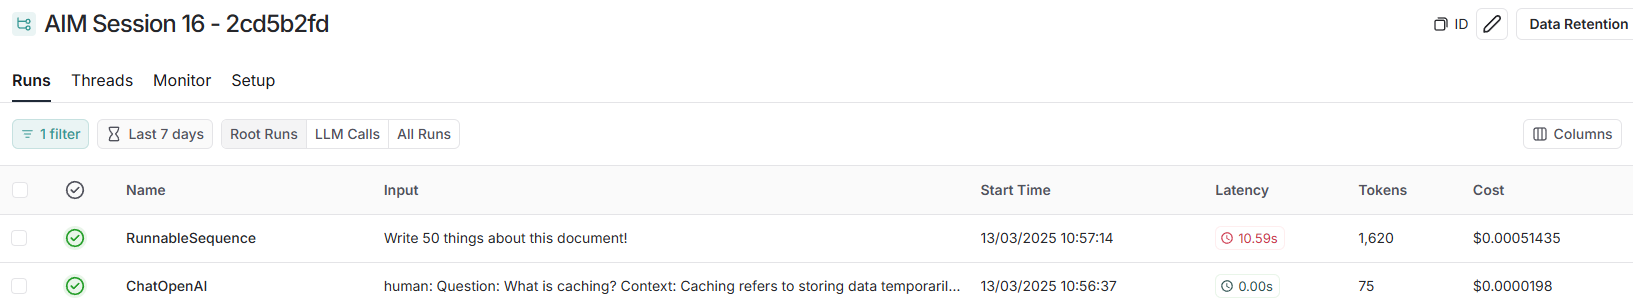